In [3]:
import pandas as pd

df = pd.read_csv('data/spam_and_ham_classification.csv')

print(df.head())

  label                                               text
0   ham  into the kingdom of god and those that are ent...
1  spam  there was flow at hpl meter 1505 on april firs...
2   ham  take a look at this one campaign for bvyhprice...
3  spam  somu wrote actually thats what i was looking f...
4  spam  fathi boudra wrote i fixed the issue in the sv...


In [4]:
# Split into Train, Validation, Test (70%, 10%, 20%)

from sklearn.model_selection import train_test_split

dataX = df['text']
dataY = df['label']

train_ratio = 0.70
validation_ratio = 0.10
test_ratio = 0.20

x_train, x_temp, y_train, y_temp = train_test_split(dataX, dataY, test_size=1 - train_ratio)

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=test_ratio/(test_ratio + validation_ratio)) 

label_map = {'ham': 0, 'spam': 1}
y_train = [label_map[label] for label in y_train]
y_val = [label_map[label] for label in y_val]
y_test = [label_map[label] for label in y_test]

print(x_train, x_val, x_test)

2218    important news headlines un is controlled by u...
6435    dear sirs aegis capital group llc aegis is a...
458     best buy to the site viagra escapenumber pills...
6298    to all sitara users :\nthe sitara system will ...
3476    the research group :\nit is with a deep sense ...
                              ...                        
725     tom -\ngiven the difficulty we ' re having get...
2776    on fri escapenumber jun escapenumber escapenum...
2264    youngsluts youngteens youpizone youporn youprn...
2255     usta pk company reports escapenumber escapenu...
3935    hey charlie ,\nfor the 31 st , i show that the...
Name: text, Length: 6992, dtype: object 1643    great news canadianpharmacy has announced a ha...
5330    info aziende b reti di vendita agenti di comme...
2889    submitting your website in search engines may ...
6878    good morning ,\nwe we offer latest oem package...
9943    able black men . reason law notice differ . fr...
                              ..

In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch

# Tokenize the datasets
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def encode_texts(texts):
    return tokenizer(list(texts), truncation=True, padding=True)

train_encodings = encode_texts(x_train)
val_encodings = encode_texts(x_val)
test_encodings = encode_texts(x_test)

class SpamHamDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = list(labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = SpamHamDataset(train_encodings, y_train)
val_dataset = SpamHamDataset(val_encodings, y_val)
test_dataset = SpamHamDataset(test_encodings, y_test)

model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

# Evaluate on test set
test_results = trainer.evaluate(test_dataset)
print('Test set results:', test_results)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


KeyboardInterrupt: 

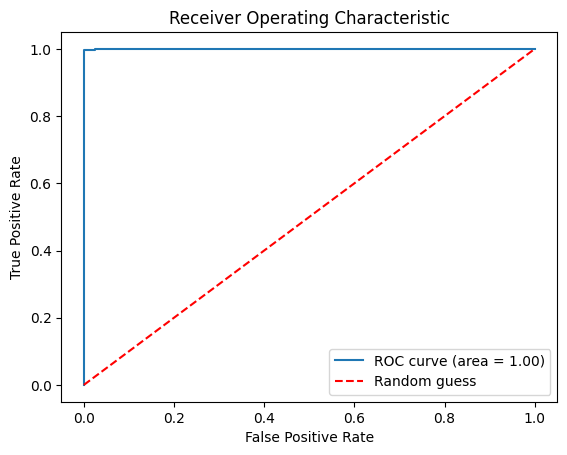

In [11]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

# Load tokenizer and model from checkpoint
checkpoint_dir = "results/checkpoint-2622"
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("results/checkpoint-2622")
model.eval()

# Prepare test data (assuming x_test and y_test are lists of texts and labels)
probs = []
for text in x_test:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(model.device)
    with torch.no_grad():
        outputs = model(**inputs)
        prob = torch.nn.functional.softmax(outputs.logits, dim=-1)[0, 1].item()  # Probability for class 1 (spam)
        probs.append(prob)

test_df = pd.DataFrame({
    'labels': y_test,
    'predictions': probs
})

fpr, tpr, _ = roc_curve(test_df['labels'], test_df['predictions'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

In [12]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# After training, evaluate:
test_results = trainer.evaluate(test_dataset)
print(test_results)

print("Accuracy:", test_results['eval_accuracy'])
print("Precision:", test_results['eval_precision'])
print("Recall:", test_results['eval_recall'])
print("F1 Score:", test_results['eval_f1'])

{'eval_loss': 0.016622770577669144, 'eval_model_preparation_time': 0.0007, 'eval_accuracy': 0.996996996996997, 'eval_precision': 0.9956043956043956, 'eval_recall': 0.9977973568281938, 'eval_f1': 0.9966996699669967, 'eval_runtime': 12.1311, 'eval_samples_per_second': 164.701, 'eval_steps_per_second': 20.608}
Accuracy: 0.996996996996997
Precision: 0.9956043956043956
Recall: 0.9977973568281938
F1 Score: 0.9966996699669967


In [ ]:
# Test a sample input
sample_text = "What's the best way to learn machine learning?"
inputs = tokenizer(sample_text, return_tensors="pt", truncation=True, padding=True).to(model.device)
outputs = model(**inputs)
probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
max_prob, predicted_class = torch.max(probs, dim=1)
confidence_threshold = 0.8

print(f"Predicted class: {predicted_class.item()}, Confidence: {max_prob.item():.4f}")

if max_prob.item() < confidence_threshold:
    print("Model is unsure. Please review manually.")
else:
    if predicted_class.item() == 1:
        print("The message is classified as: SPAM")
    else:
        print("The message is classified as: HAM")


Predicted class: 1, Confidence: 0.9822
The message is classified as: SPAM
